<div style="text-align:center;">
Fine-tuning YOLOv5-Large Model for tracking the Tip Locations of Surgical Tools.
</div>


In [1]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 16111, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 16111 (delta 7), reused 5 (delta 0), pack-reused 16089
Receiving objects: 100% (16111/16111), 14.84 MiB | 16.84 MiB/s, done.
Resolving deltas: 100% (11026/11026), done.
/content/yolov5
HEAD is now at 064365d Update parse_opt() in export.py to work as in train.py (#10789)


In [2]:
# install required dependencies
!pip install -qr requirements.txt
!pip install roboflow
import torch
from IPython.display import Image  
from utils.downloads import attempt_download

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/190.6 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 184.3/190.6 kB 5.3 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
print('Torch Version : %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Torch Version : 2.1.0+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


In [4]:
# Importing Custom Dataset from Roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="At40wDCJBDCWt9sPt9Xu")
project = rf.workspace("wkspaceone").project("surgical-tools-cry9e")
dataset = project.version(1).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to surgical-tools-1 in yolov5pytorch:: 100%|██████████| 1382/1382 [00:00<00:00, 9083.62it/s]


In [5]:
%cd /content/yolov5

/content/yolov5


In [6]:
# read surgical-tools YAML Datacard
%cat {dataset.location}/data.yaml

names:
- Bipolar
- Clipper
- Grasper
- Hook
- Irrigator
- Scissors
- SpecimenBag
nc: 7
roboflow:
  license: CC BY 4.0
  project: surgical-tools-cry9e
  url: https://universe.roboflow.com/wkspaceone/surgical-tools-cry9e/dataset/1
  version: 1
  workspace: wkspaceone
test: ../test/images
train: surgical-tools-1/train/images
val: surgical-tools-1/valid/images


In [7]:
# read number of classes from surgical-tools YAML Datacard
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [8]:
num_classes

'7'

# Model Configuration


In [9]:
# load YOLOv5-large config
%cat /content/yolov5/models/yolov5l.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]], 

In [10]:
# writing custom YOLOv5-large config for surgical-tool data (update model-depth-multiple & layer-channel-multiple)
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [11]:
%%writetemplate /content/yolov5/models/custom_yolov5l.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 1.0  # update as per the required model 
width_multiple: 1.0  # update as per the required model 

anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [12]:
# fine-tuning YOLO Model
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5l.yaml --weights '' --name yolov5l_results  --cache

/content/yolov5
2023-12-19 04:39:14.284336: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 04:39:14.284391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 04:39:14.285737: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 04:39:15.292177: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5l.yaml, data=/content/yolov5/surgical-tools-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False

# Plotting Evaluation Metrics

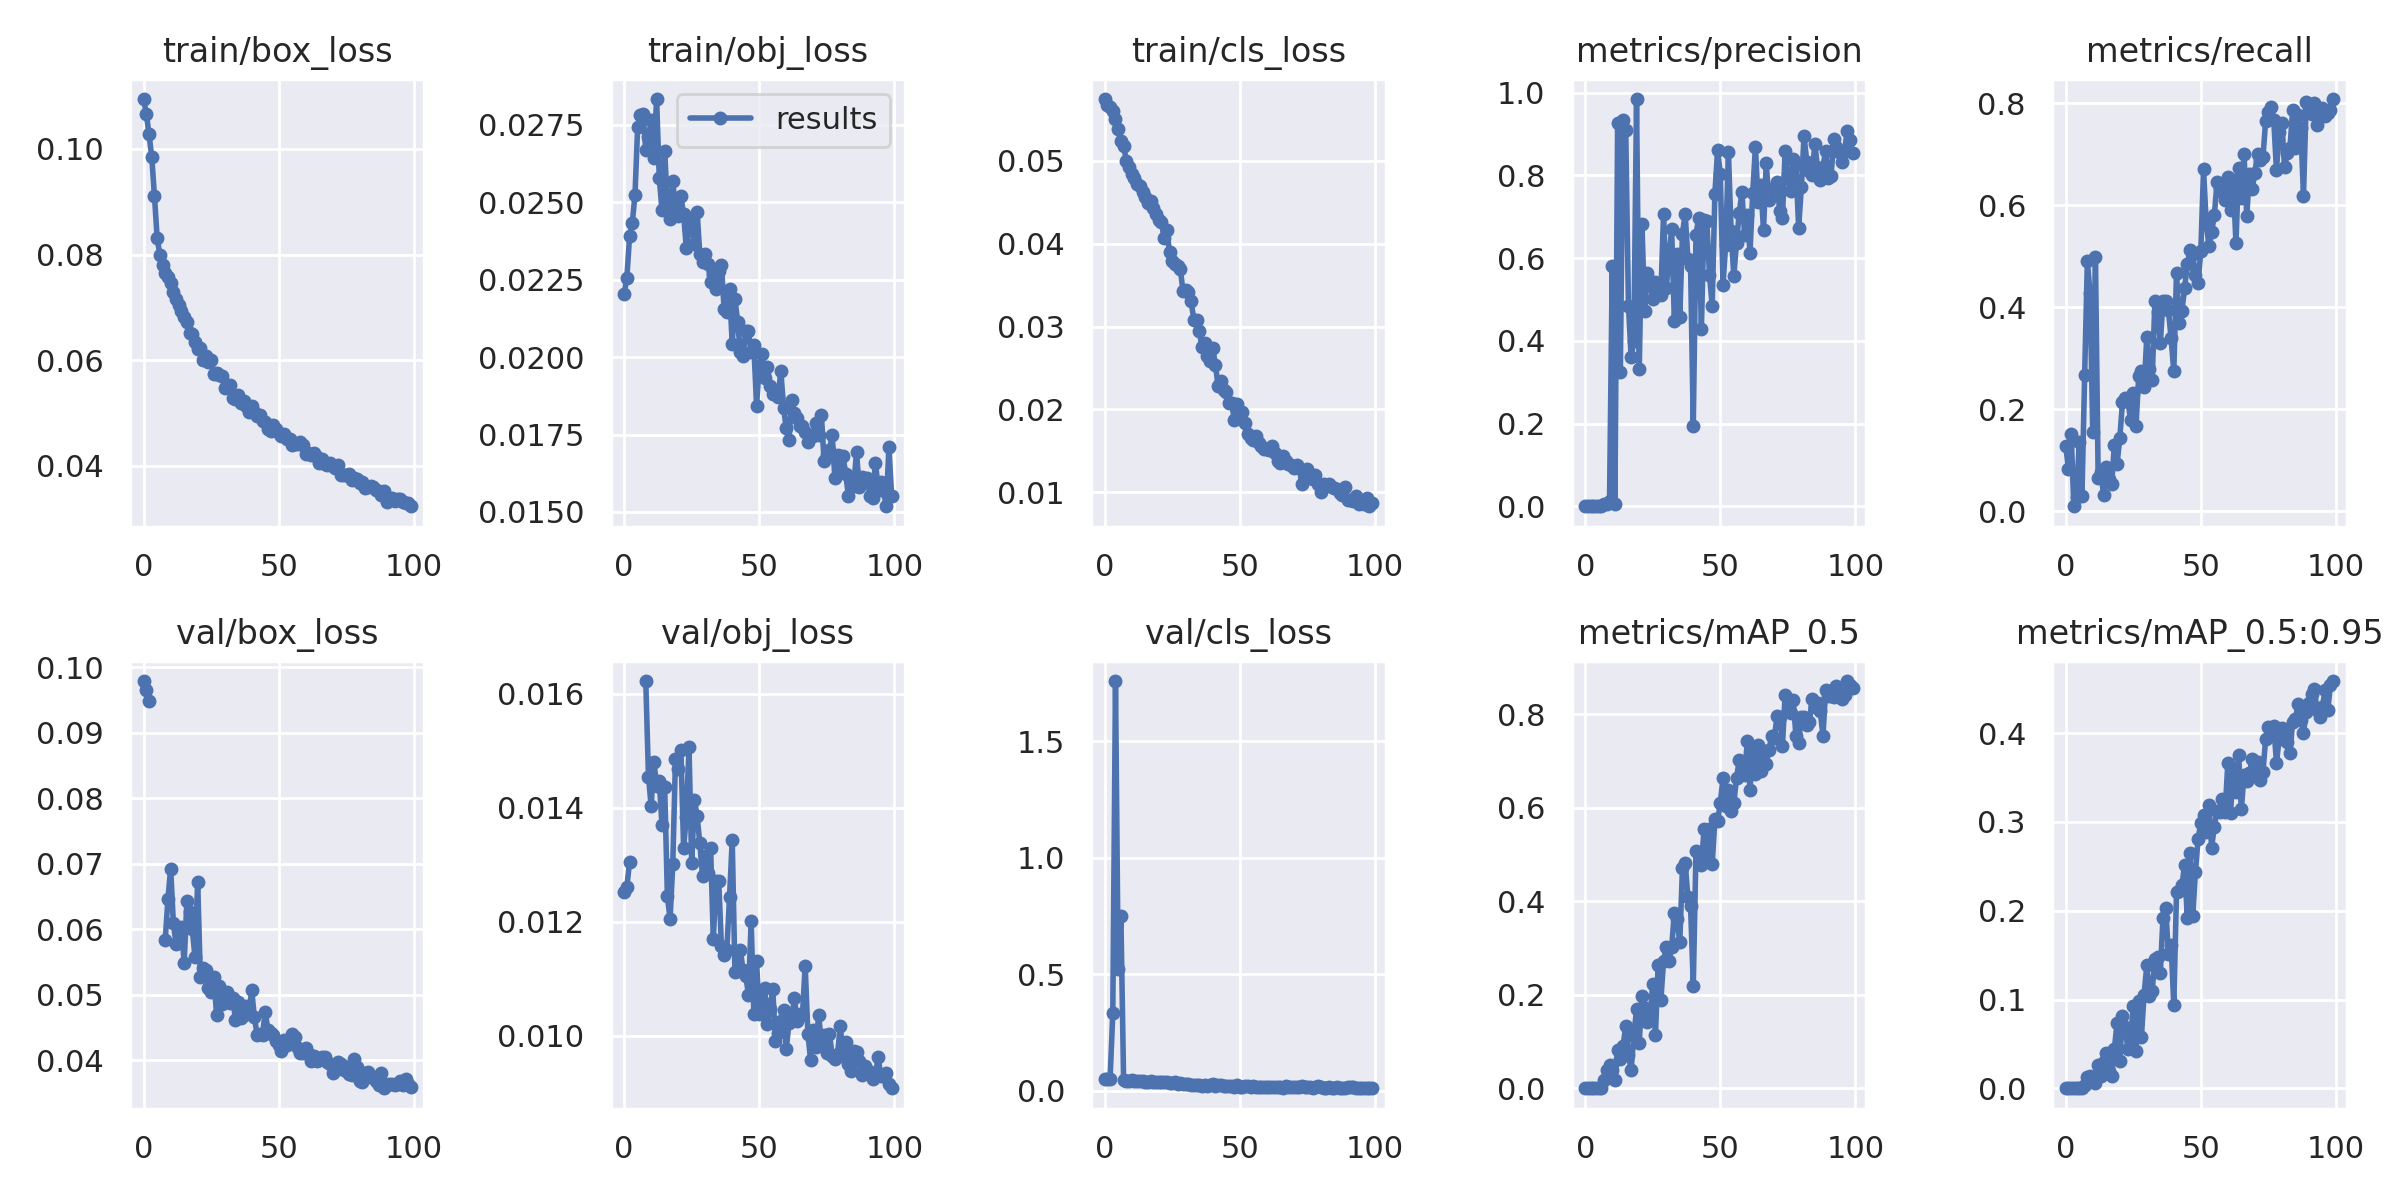

In [13]:
from utils.plots import plot_results
Image(filename='/content/yolov5/runs/train/yolov5l_results/results.png', width=1000)

# Display Augmented Train / Val Batches

--------- VALIDATION BATCH ---------


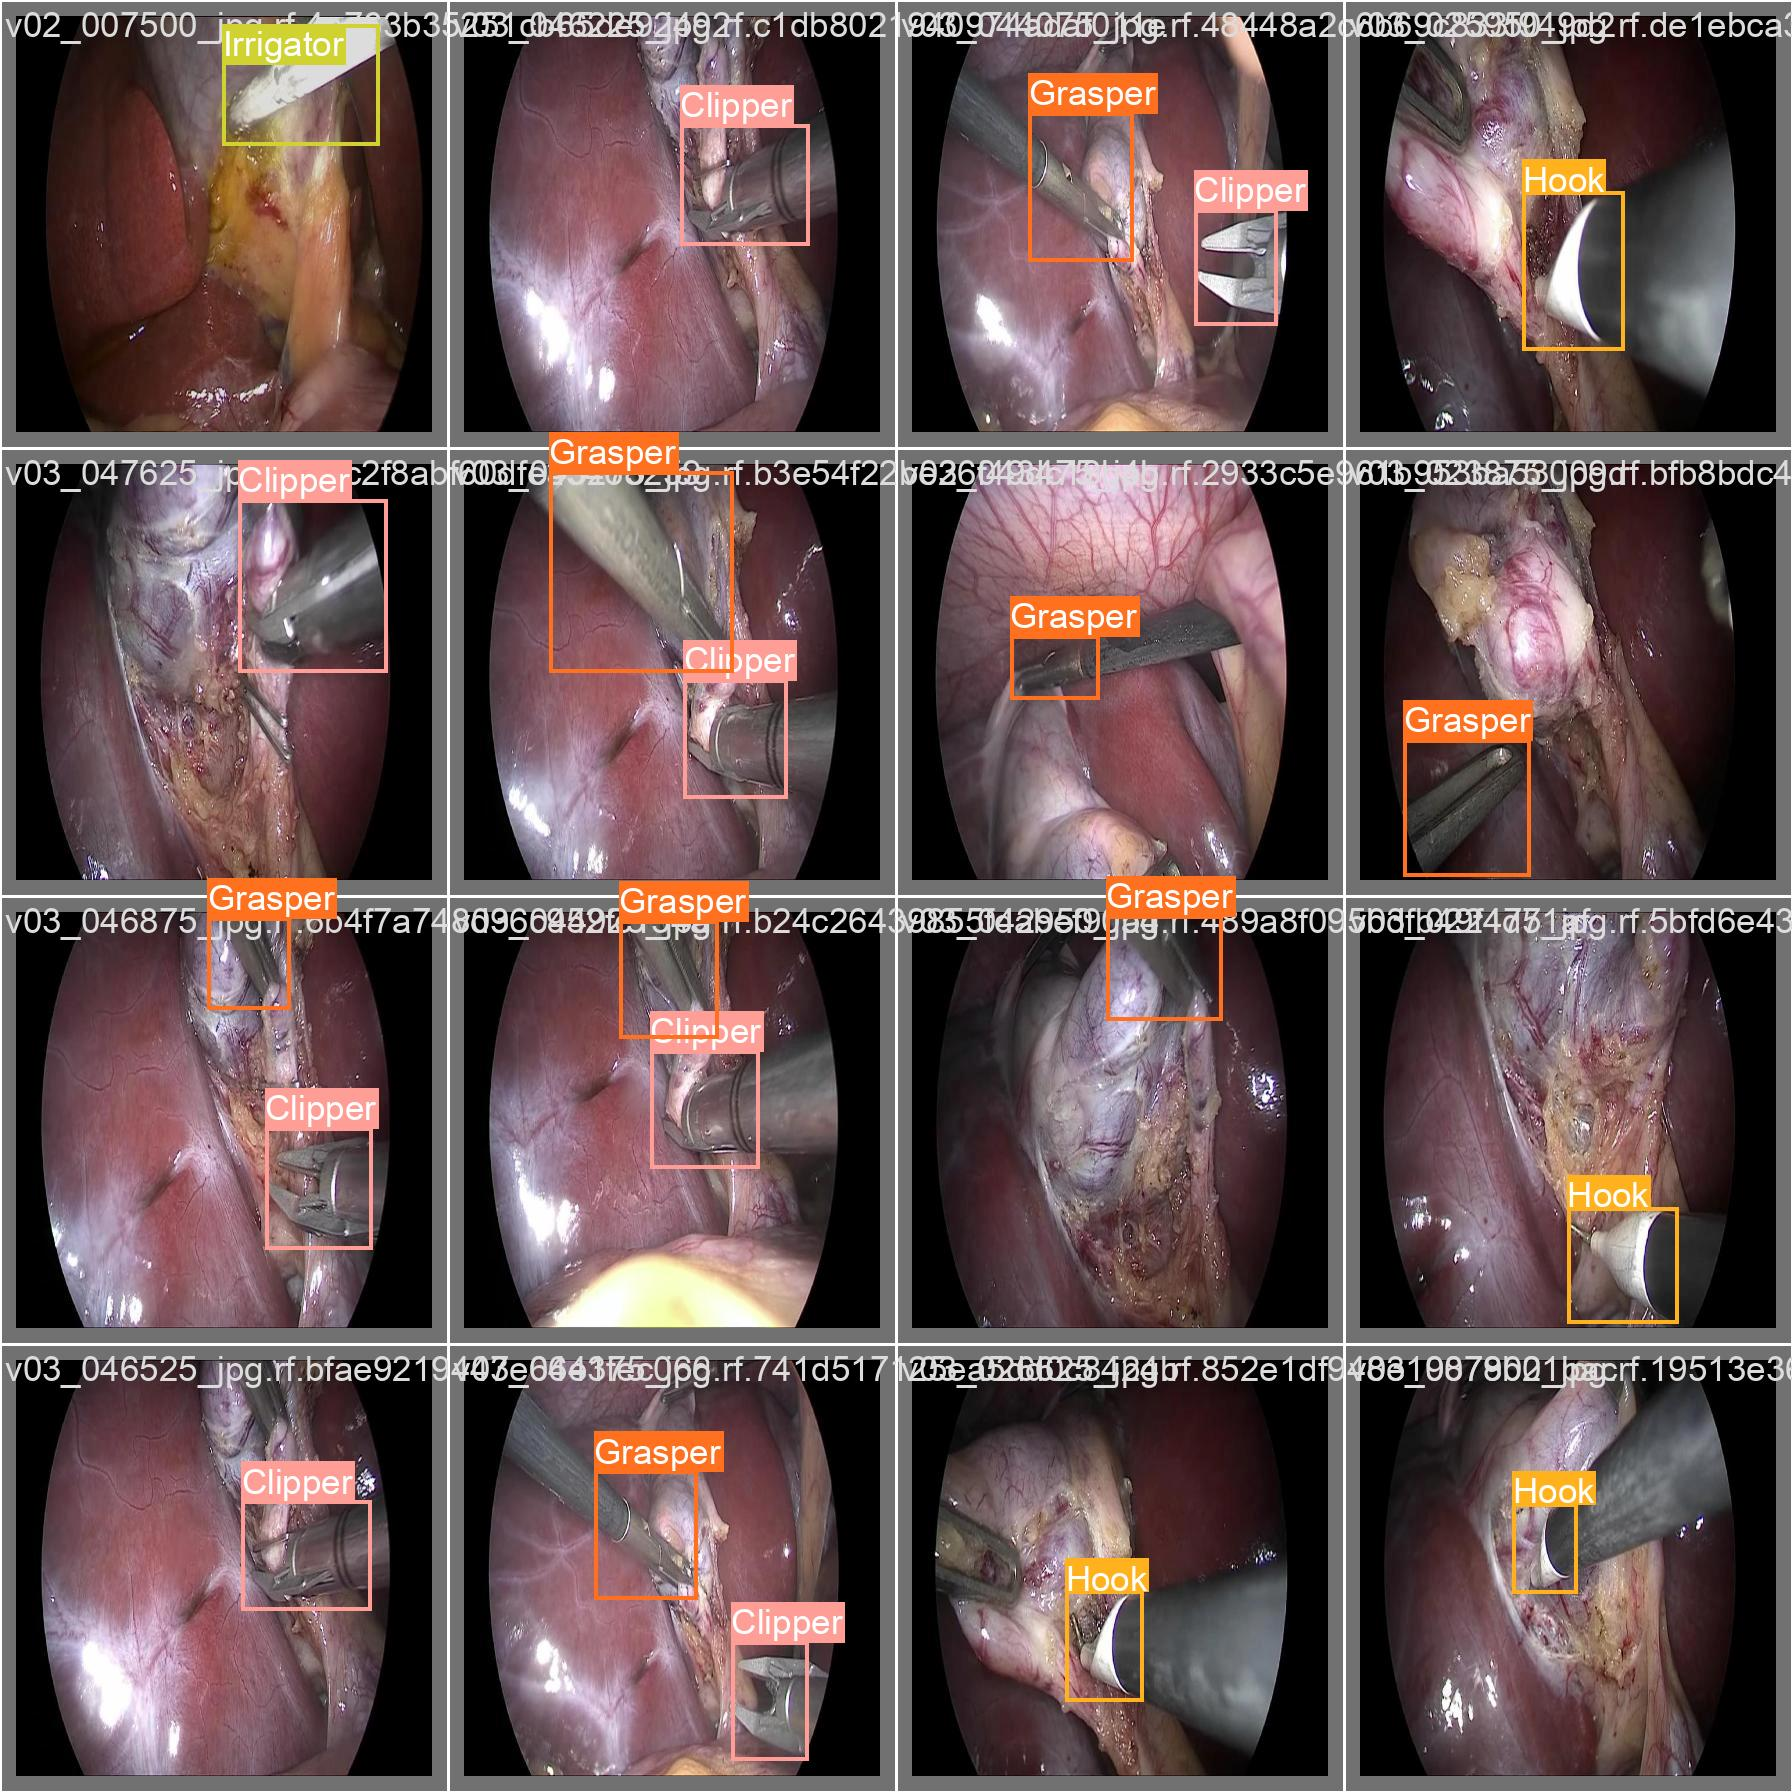

In [16]:
# Validation Batch using Mosaic Dataloader
print('--------- VALIDATION BATCH ---------')
Image(filename='/content/yolov5/runs/train/yolov5l_results/val_batch0_labels.jpg', width=900)

--------- TRAIN BATCH ---------


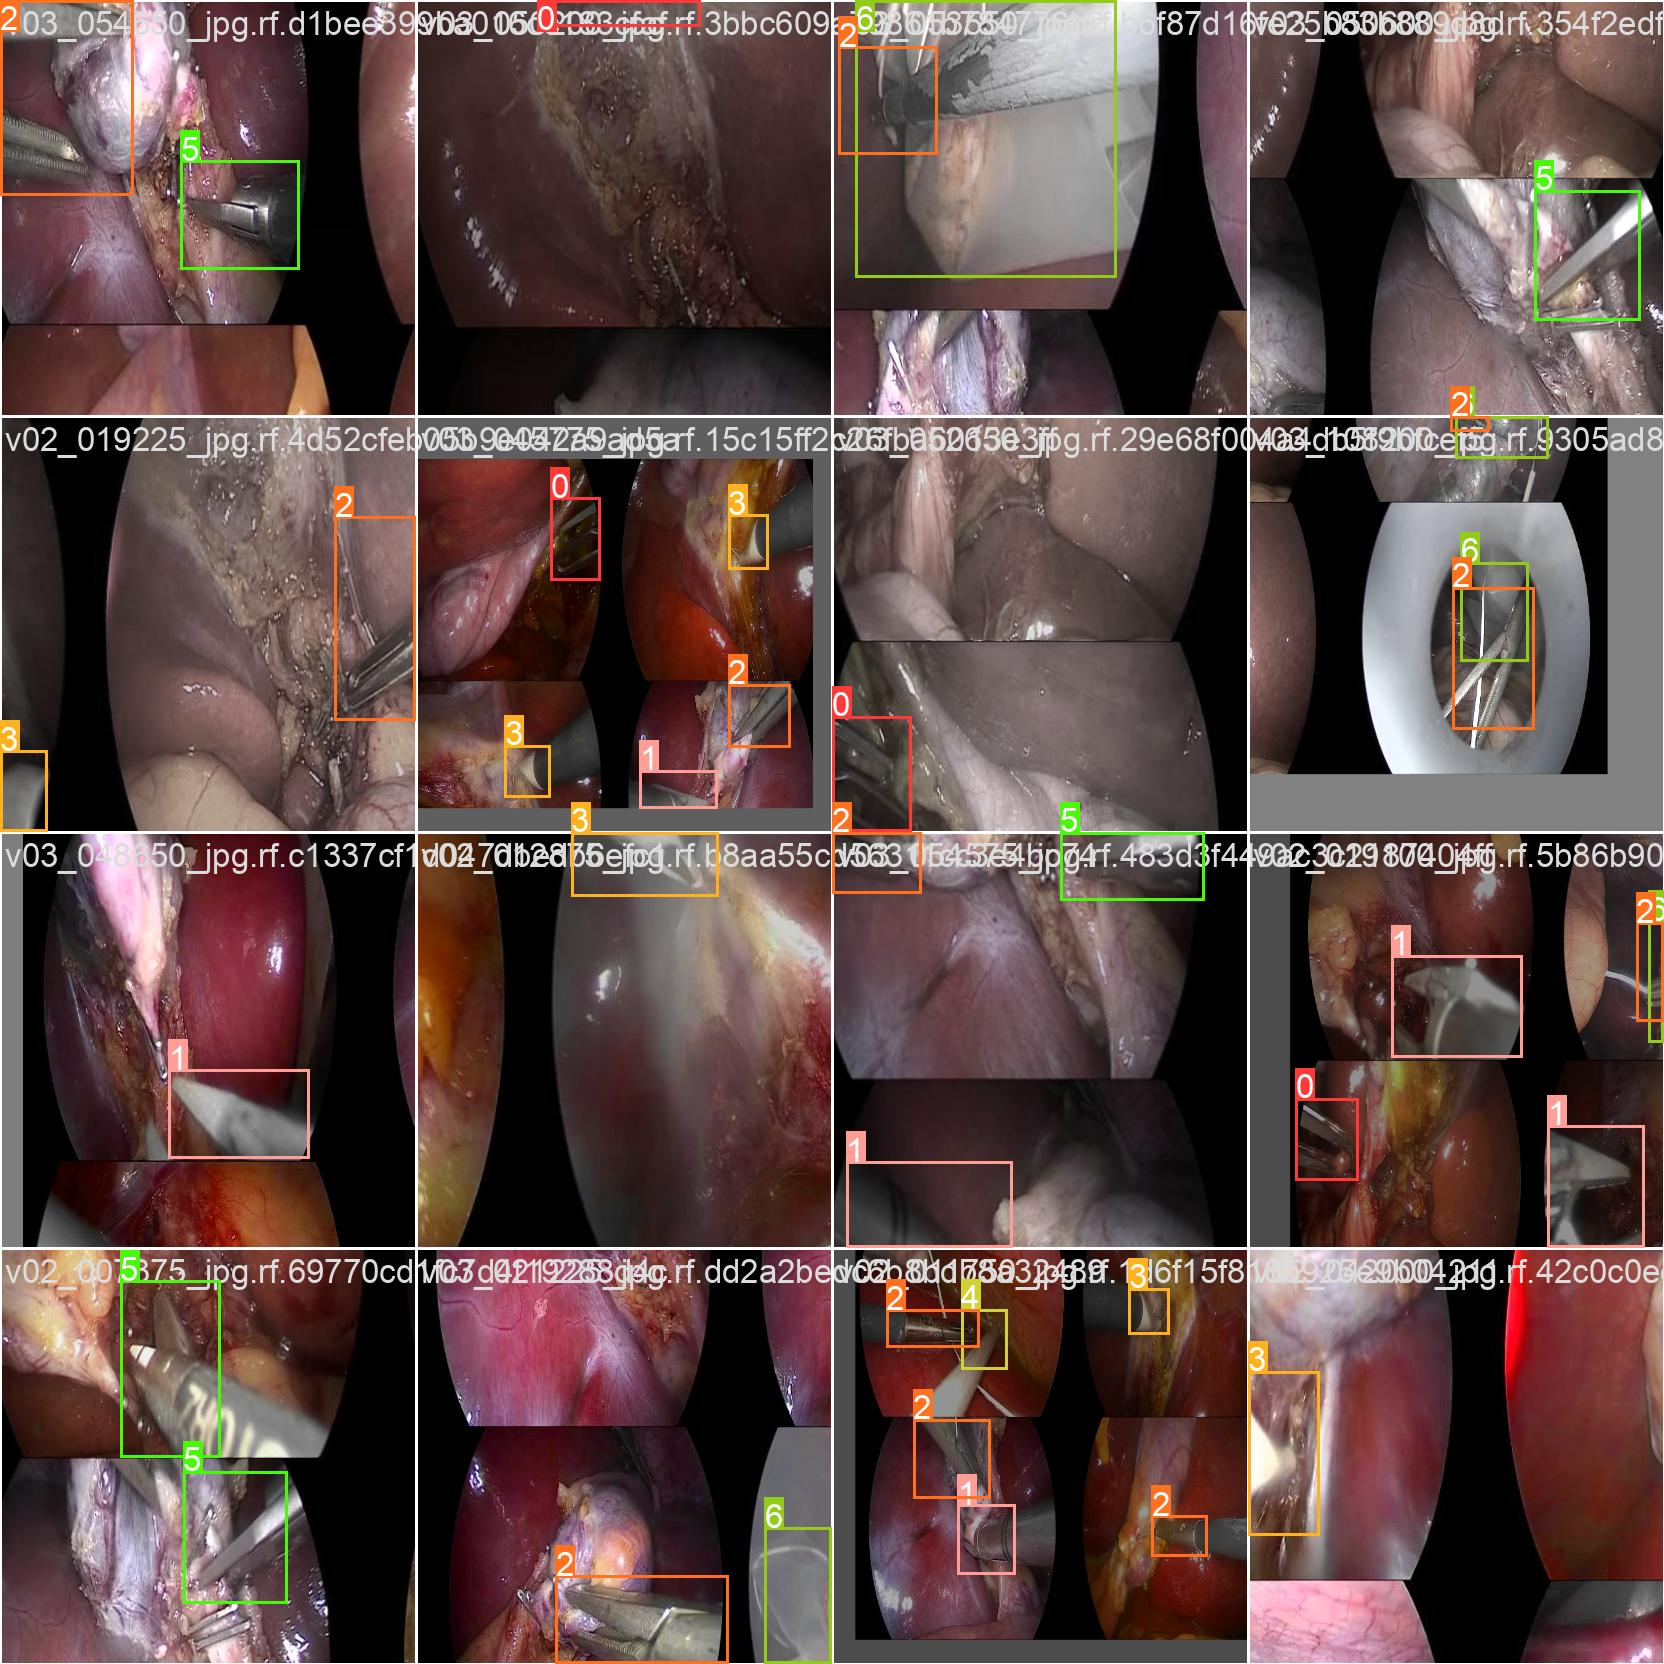

In [17]:
# Training Batch using Mosaic Dataloader
print('--------- TRAIN BATCH ---------')
Image(filename='/content/yolov5/runs/train/yolov5l_results/train_batch0.jpg', width=900)

# Inference With Trained Weights

In [18]:
%ls runs/train/yolov5l_results/weights

best.pt  last.pt


In [22]:
%cd /content/yolov5
!python detect.py --weights runs/train/yolov5l_results/weights/best.pt --conf 0.4 --source /content/yolov5/test_video.mp4

/content/yolov5
detect: weights=['runs/train/yolov5l_results/weights/best.pt'], source=/content/yolov5/test_video.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5l summary: 267 layers, 46140588 parameters, 0 gradients, 107.7 GFLOPs
video 1/1 (1/192) /content/yolov5/test_video.mp4: 384x640 1 Grasper, 54.1ms
video 1/1 (2/192) /content/yolov5/test_video.mp4: 384x640 (no detections), 32.0ms
video 1/1 (3/192) /content/yolov5/test_video.mp4: 384x640 2 Graspers, 31.9ms
video 1/1 (4/192) /content/yolov5/test_video.mp4: 384x640 2 Gra

In [35]:
# transcode the video files to embed them in the notebook
!ffmpeg -i {"/content/yolov5/test_video.mp4"} -vcodec libx264 {"/content/input.mp4"}
!ffmpeg -i {"/content/yolov5/runs/detect/exp3/test_video.mp4"} -vcodec libx264 {"/content/output.mp4"}

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

HTML(value='<h3>Raw Video</h3>')

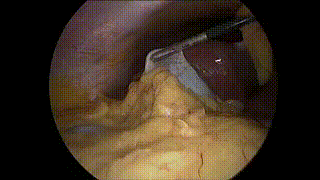

HTML(value='<h3>Tool Tracking</h3>')

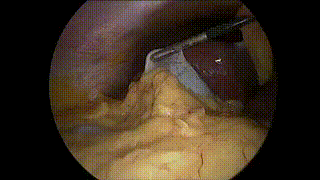

In [1]:
from ipywidgets import Video, HBox, HTML
from IPython.display import display, Image
import os 

gif_path_1 = os.path.join(os.getcwd(), 'input.gif')
gif_path_2 = os.path.join(os.getcwd(), 'output.gif')
title_1 = HTML("<h3>Raw Video</h3>")
title_2 = HTML("<h3>Tool Tracking</h3>")
display(title_1, Image(filename=gif_path_1, height = 500, width = 500))
display(title_2, Image(filename=gif_path_2, height = 500, width = 500))

